# Intro
Most Kagglers are familiar with Weighted Boxes Fusion in object detection. What about Weighted Segments Fusion (WSF) for use in instance segmentation? There are papers on the topic, but not much code, so I decided to give it a try. There are many possible approaches to this problem; my take on it is a two-stage process: Start with WBF on the bounding boxes, and then fuse the segments based on the WBF output. WSF can of course used for ensembling models too, not only TTA.   

References:
  * [Create COCO annotations for Sartorius dataset](https://www.kaggle.com/mistag/sartorius-create-coco-annotations)
  * [Cell shape analysis](https://www.kaggle.com/mistag/sartorius-cell-shape-analysis)
  * [Trained CenterMask2 model](https://www.kaggle.com/mistag/train-sartorius-detectron2-centermask2)
  * [Competition Metric : mAP IoU](https://www.kaggle.com/theoviel/competition-metric-map-iou)
  * [Weighted boxes fusion](https://github.com/ZFTurbo/Weighted-Boxes-Fusion) by [ZFTurbo](https://kaggle.com/zfturbo)

# Libraries installation
Install Detectron2, WBF, Centermask2 et.al.

In [1]:
!pip install --no-index \
/kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/detectron2-0.6-cp37-cp37m-linux_x86_64.whl \
--find-links=/kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2

Looking in links: /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/detectron2-0.6-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/iopath-0.1.9-py3-none-any.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/hydra_core-1.1.1-py3-none-any.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/fvcore-0.1.5.post20211023-py3-none-any.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/omegaconf-2.1.1-py3-none-any.whl
Processing /kaggle/input/detectron2-download-code-for-offline-install-ii/detectron2/black-21.4b2-py3-none-any.whl
Processing /kaggle/input/detectron2-download-code-for-offline-

In [2]:
!pip install --no-index \
/kaggle/input/wbfdownloadcodeforofflineinstallation/Weighted-Boxes-Fusion/ensemble_boxes-1.0.8-py3-none-any.whl \
--find-links=/kaggle/input/wbfdownloadcodeforofflineinstallation/Weighted-Boxes-Fusion

Looking in links: /kaggle/input/wbfdownloadcodeforofflineinstallation/Weighted-Boxes-Fusion
Processing /kaggle/input/wbfdownloadcodeforofflineinstallation/Weighted-Boxes-Fusion/ensemble_boxes-1.0.8-py3-none-any.whl


In [3]:
!cp -R /kaggle/input/centermask2litev19slim13000 centermask2

In [4]:
import numpy as np
import pandas as pd
import os, json, cv2, random
import matplotlib.pyplot as plt
from matplotlib import colors
import glob, gc
from ensemble_boxes import nms
from skimage import measure
import albumentations as A
from skimage import measure
from scipy import stats
import torch
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# Create tracking WBF
The WBF algorithm returns fused boxes, and we need to keep track of which original boxes were used for each fused box to process the correct masks afterwards. A tracking WBF function is created below that returns a list of original boxes are created below. This will be stage one in the WSF algorithm.

In [5]:
%%writefile wbf_tracking.py
# coding: utf-8
__author__ = 'ZFTurbo: https://kaggle.com/zfturbo'
# Modified by Mista G: https://www.kaggle.com/mistag

import warnings
import numpy as np
from numba import jit

@jit(nopython=True)
def bb_intersection_over_union(A, B) -> float:
    xA = max(A[0], B[0])
    yA = max(A[1], B[1])
    xB = min(A[2], B[2])
    yB = min(A[3], B[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)

    if interArea == 0:
        return 0.0

    # compute the area of both the prediction and ground-truth rectangles
    boxAArea = (A[2] - A[0]) * (A[3] - A[1])
    boxBArea = (B[2] - B[0]) * (B[3] - B[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou


def prefilter_boxes(boxes, scores, labels, weights, thr):
    # Create dict with boxes stored by its label
    new_boxes = dict()

    for t in range(len(boxes)):

        if len(boxes[t]) != len(scores[t]):
            print('Error. Length of boxes arrays not equal to length of scores array: {} != {}'.format(len(boxes[t]), len(scores[t])))
            sys.exit()

        if len(boxes[t]) != len(labels[t]):
            print('Error. Length of boxes arrays not equal to length of labels array: {} != {}'.format(len(boxes[t]), len(labels[t])))
            sys.exit()

        for j in range(len(boxes[t])):
            score = scores[t][j]
            if score < thr:
                continue
            label = int(labels[t][j])
            box_part = boxes[t][j]
            x1 = max(float(box_part[0]), 0.)
            y1 = max(float(box_part[1]), 0.)
            x2 = max(float(box_part[2]), 0.)
            y2 = max(float(box_part[3]), 0.)

            # Box data checks
            if x2 < x1:
                warnings.warn('X2 < X1 value in box. Swap them.')
                x1, x2 = x2, x1
            if y2 < y1:
                warnings.warn('Y2 < Y1 value in box. Swap them.')
                y1, y2 = y2, y1
            if x1 > 1:
                warnings.warn('X1 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                x1 = 1
            if x2 > 1:
                warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                x2 = 1
            if y1 > 1:
                warnings.warn('Y1 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                y1 = 1
            if y2 > 1:
                warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
                y2 = 1
            if (x2 - x1) * (y2 - y1) == 0.0:
                warnings.warn("Zero area box skipped: {}.".format(box_part))
                continue

            # [label, score, weight, model index, x1, y1, x2, y2]
            b = [int(label), float(score) * weights[t], weights[t], t, x1, y1, x2, y2]
            if label not in new_boxes:
                new_boxes[label] = []
            new_boxes[label].append(b)

    # Sort each list in dict by score and transform it to numpy array
    for k in new_boxes:
        current_boxes = np.array(new_boxes[k])
        new_boxes[k] = current_boxes[current_boxes[:, 1].argsort()[::-1]]

    return new_boxes


def get_weighted_box(boxes, conf_type='avg'):
    """
    Create weighted box for set of boxes
    :param boxes: set of boxes to fuse
    :param conf_type: type of confidence one of 'avg' or 'max'
    :return: weighted box (label, score, weight, x1, y1, x2, y2)
    """

    box = np.zeros(8, dtype=np.float32)
    conf = 0
    conf_list = []
    w = 0
    for b in boxes:
        box[4:] += (b[1] * b[4:])
        conf += b[1]
        conf_list.append(b[1])
        w += b[2]
    box[0] = boxes[0][0]
    if conf_type == 'avg':
        box[1] = conf / len(boxes)
    elif conf_type == 'max':
        box[1] = np.array(conf_list).max()
    elif conf_type in ['box_and_model_avg', 'absent_model_aware_avg']:
        box[1] = conf / len(boxes)
    box[2] = w
    box[3] = -1 # model index field is retained for consistensy but is not used.
    box[4:] /= conf
    return box


def find_matching_box(boxes_list, new_box, match_iou):
    best_iou = match_iou
    best_index = -1
    for i in range(len(boxes_list)):
        box = boxes_list[i]
        if box[0] != new_box[0]:
            continue
        iou = bb_intersection_over_union(box[4:], new_box[4:])
        if iou > best_iou:
            best_index = i
            best_iou = iou

    return best_index, best_iou


def weighted_boxes_fusion_tracking(boxes_list, scores_list, labels_list, weights=None, iou_thr=0.55, skip_box_thr=0.0, conf_type='avg', allows_overflow=False):
    '''
    :param boxes_list: list of boxes predictions from each model, each box is 4 numbers.
    It has 3 dimensions (models_number, model_preds, 4)
    Order of boxes: x1, y1, x2, y2. We expect float normalized coordinates [0; 1]
    :param scores_list: list of scores for each model
    :param labels_list: list of labels for each model
    :param weights: list of weights for each model. Default: None, which means weight == 1 for each model
    :param iou_thr: IoU value for boxes to be a match
    :param skip_box_thr: exclude boxes with score lower than this variable
    :param conf_type: how to calculate confidence in weighted boxes. 'avg': average value, 'max': maximum value, 'box_and_model_avg': box and model wise hybrid weighted average, 'absent_model_aware_avg': weighted average that takes into account the absent model.
    :param allows_overflow: false if we want confidence score not exceed 1.0

    :return: boxes: boxes coordinates (Order of boxes: x1, y1, x2, y2).
    :return: scores: confidence scores
    :return: labels: boxes labels
    :return: wbfo: original boxes coordinates for each fused box
    '''

    if weights is None:
        weights = np.ones(len(boxes_list))
    if len(weights) != len(boxes_list):
        print('Warning: incorrect number of weights {}. Must be: {}. Set weights equal to 1.'.format(len(weights), len(boxes_list)))
        weights = np.ones(len(boxes_list))
    weights = np.array(weights)

    if conf_type not in ['avg', 'max', 'box_and_model_avg', 'absent_model_aware_avg']:
        print('Unknown conf_type: {}. Must be "avg", "max" or "box_and_model_avg", or "absent_model_aware_avg"'.format(conf_type))
        sys.exit()

    filtered_boxes = prefilter_boxes(boxes_list, scores_list, labels_list, weights, skip_box_thr)
    if len(filtered_boxes) == 0:
        return np.zeros((0, 4)), np.zeros((0,)), np.zeros((0,)), np.zeros((0, 4))
    
    overall_boxes = []
    original_boxes = []
    for label in filtered_boxes:
        boxes = filtered_boxes[label]
        new_boxes = []
        weighted_boxes = []
        # Clusterize boxes
        for j in range(0, len(boxes)):
            index, best_iou = find_matching_box(weighted_boxes, boxes[j], iou_thr)
            if index != -1:
                new_boxes[index].append(boxes[j])
                weighted_boxes[index] = get_weighted_box(new_boxes[index], conf_type)
            else:
                new_boxes.append([boxes[j].copy()])
                weighted_boxes.append(boxes[j].copy())
        # Rescale confidence based on number of models and boxes
        original_boxes.append(new_boxes)
        for i in range(len(new_boxes)):
            clustered_boxes = np.array(new_boxes[i])
            if conf_type == 'box_and_model_avg':
                # weighted average for boxes
                weighted_boxes[i][1] = weighted_boxes[i][1] * len(clustered_boxes) / weighted_boxes[i][2]
                # identify unique model index by model index column
                _, idx = np.unique(clustered_boxes[:, 3], return_index=True)
                # rescale by unique model weights
                weighted_boxes[i][1] = weighted_boxes[i][1] *  clustered_boxes[idx, 2].sum() / weights.sum()
            elif conf_type == 'absent_model_aware_avg':
                # get unique model index in the cluster
                models = np.unique(clustered_boxes[:, 3]).astype(int)
                # create a mask to get unused model weights
                mask = np.ones(len(weights), dtype=bool)
                mask[models] = False
                # absent model aware weighted average
                weighted_boxes[i][1] = weighted_boxes[i][1] * len(clustered_boxes) / (weighted_boxes[i][2] + weights[mask].sum())
            elif conf_type == 'max':
                weighted_boxes[i][1] = weighted_boxes[i][1] / weights.max()
            elif not allows_overflow:
                weighted_boxes[i][1] = weighted_boxes[i][1] * min(len(weights), len(clustered_boxes)) / weights.sum()
            else:
                weighted_boxes[i][1] = weighted_boxes[i][1] * len(clustered_boxes) / weights.sum()
        overall_boxes.append(np.array(weighted_boxes))
    overall_boxes = np.concatenate(overall_boxes, axis=0)
    sidx = overall_boxes[:, 1].argsort()
    overall_boxes = overall_boxes[sidx[::-1]]
    boxes = overall_boxes[:, 4:]
    scores = overall_boxes[:, 1]
    labels = overall_boxes[:, 0]
    # sort originals accoring to wbf
    original_boxes = original_boxes[0]
    wbfo = [original_boxes[i] for i in sidx[::-1]]
    return boxes, scores, labels, wbfo

Writing wbf_tracking.py


In [6]:
from wbf_tracking import weighted_boxes_fusion_tracking

# Import trained model
Then we need a trained model to test on. We'll use [this one based on Detectron2](https://www.kaggle.com/mistag/pred-sartorius-detectron2-centermask2), which is pretty poor performing, but plenty good enough for this exercise.  

In the first part, we configure the model to max 20 detections, to have some easy data to work on.

In [7]:
#Configure model for inference:
%cd /kaggle/working/centermask2

from centermask.config import get_cfg # important! Use get_cfg from the centermask repo and not Detectron2

cfg = get_cfg()
cfg.merge_from_file("/kaggle/input/centermask2-lite-v-39/test.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = '/kaggle/input/centermask2-lite-v-39/output/model_final.pth'
cfg.MODEL.FCOS.POST_NMS_TOPK_TEST = 20 # Max number of detections per image
predictor20 = DefaultPredictor(cfg)

/kaggle/working/centermask2


Next, we read train.csv from the data set and the test data set that was used in training. The latter will be used to evaluate the performance of the TTA function.

In [8]:
df = pd.read_csv('/kaggle/input/sartorius-cell-instance-segmentation/train.csv')
df = df.groupby('id').agg(list).reset_index()

for col in df.columns[2:]:
    df[col] = df[col].apply(
        lambda x: np.unique(x)[0] if len(np.unique(x)) == 1 else np.unique(x)
    )

with open ('/kaggle/input/cellcleanastromask/test_fold_0.json', 'r') as f:
    tset = json.load(f)

test_fids = []
for i in range(len(tset['images'])):
    test_fids.append(tset['images'][i]['file_name'].split('/')[-1].split('.')[0])

shsy5y_fids, astro_fids, cort_fids = [],[],[]
for fid in test_fids:
    ctype = df[df.id == fid].cell_type.iloc[0]
    if ctype == 'shsy5y':
        shsy5y_fids.append(fid)
    elif ctype == 'astro':
        astro_fids.append(fid)
    else:
        cort_fids.append(fid)

print('Test files per class: shsy5y={}, astro={}, cort={}'.format(len(shsy5y_fids), len(astro_fids), len(cort_fids)))

Test files per class: shsy5y=31, astro=27, cort=64


# TTA
The TTA function is defined below. The image is transformed according to the TTA list, predictions are made after each transform, and the predicted boxes and masks are transformed back to the original orientation, before everything is returned as lists. We create a dict with box coordinates as keys to the mask list, so we can fetch the correct mask in stage two of WSF.

The TT augmentations will be:
  * Horizontal flip
  * Vertical flip
  * Rotate 180 degrees  
  
Along with the original, this will result in 4 predictions per image.

In [9]:
# create dict key from bbox
def bbox_to_key(bbox):
    return str(np.round(bbox, 6))

# TTA inputs:
# file: image to process
# predictor_list: list of predictors to use, single or multiple for ensembling
# aug_list: list of augmentations to perform. Augmentations must be "bidirectional" - applying twice will get back to original.
#           Also augmentations must support image, bboxes and masks
def TTA(file, predictor_list, aug_list=[None]):
    boxes = []
    box_scores = []
    masks = []
    masks_lkup =[]
    pclass = []
    im = cv2.imread(file)
    for predict in predictor_list:
        for aug in aug_list:
            # perform augmentations
            if aug is not None:
                transform = aug
                ima = transform(image=im)['image']
            else:
                ima = im
            # make prediction
            pred = predict(ima)
            h, w = pred['instances'].image_size[0], pred['instances'].image_size[1]
            classes = pred['instances'].pred_classes.cpu().numpy()-1
            if len(pclass) == 0:
                pclass = classes
            else:
                pclass = np.concatenate((pclass, classes))
            # get box predictions, and nomrmalize to 0-1 range
            pred_boxes = [A.normalize_bbox(box, h, w) for box in pred['instances'].pred_boxes.tensor.cpu().numpy()]
            # transform back to original
            if aug is not None:
                pred_boxes = transform(image=ima, bboxes=pred_boxes)['bboxes']
            # get mask prediction
            pred_masks = pred['instances'].pred_masks.cpu().numpy()*1
            # transform back to original
            if aug is not None:
                pred_masks = transform(image=ima, masks=pred_masks)['masks']
            # lookup table for bbox to mask index reference
            pred_dict = {}
            for i in range(len(pred_boxes)):
                pred_dict[bbox_to_key(pred_boxes[i])] = i
            # append results to list
            boxes.append(np.array(pred_boxes))
            box_scores.append(np.array(pred['instances'].scores.detach().cpu().numpy()))
            masks.append(np.array(pred_masks, dtype=np.uint8))
            masks_lkup.append(pred_dict)
    
            del pred, pred_boxes, pred_masks, ima, pred_dict
    
    del im
    gc.collect()
    predicted_class = stats.mode(pclass)[0][0]
    return boxes, box_scores, masks, masks_lkup, predicted_class

## Test TTA
We will run TTA on an image from the validation data set, created in [this notebook](https://www.kaggle.com/mistag/sartorius-create-coco-annotations). The predictor is configured to return only 20 detections. The predictions are visualized on the augmented images.

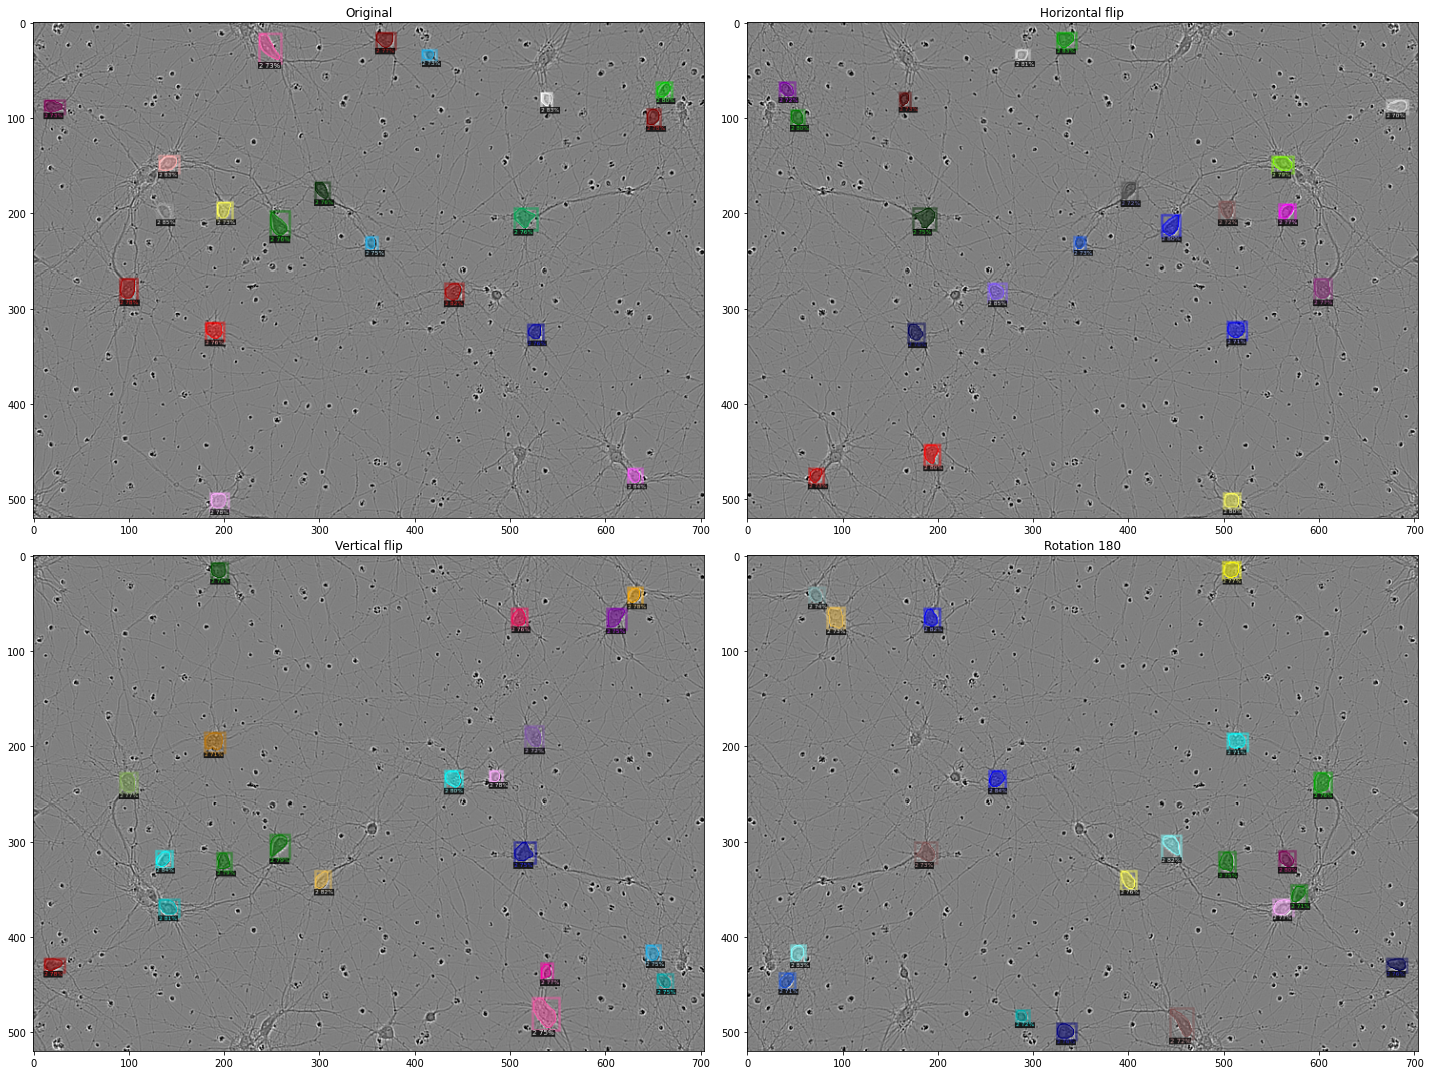

In [10]:
TITLES = ['Original', 'Horizontal flip', 'Vertical flip', 'Rotation 180']

def plt_pred(file):
    fig = plt.figure(figsize=(20,15))
    im = cv2.imread(file)
    # org
    fig.add_subplot(2, 2, 1)
    plt.tight_layout()
    outputs = predictor20(im)
    v = Visualizer(im[:, :, ::-1])
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.title(TITLES[0])
    plt.imshow(out.get_image()[:, :, ::-1]);
    # flip horizontal/vertical/both
    for i in range(1, -2, -1):
        imh = cv2.flip(im, i)
        fig.add_subplot(2, 2, 3-i)
        plt.tight_layout()
        outputs = predictor20(imh)
        v = Visualizer(imh[:, :, ::-1])
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.title(TITLES[2-i])
        plt.imshow(out.get_image()[:, :, ::-1]);

FILE = '/kaggle/input/sartorius-cell-instance-segmentation/train/'+cort_fids[0]+'.png'
plt_pred(FILE)

Next, call the TTA function and plot output predictions that shall be mapped back to original image:

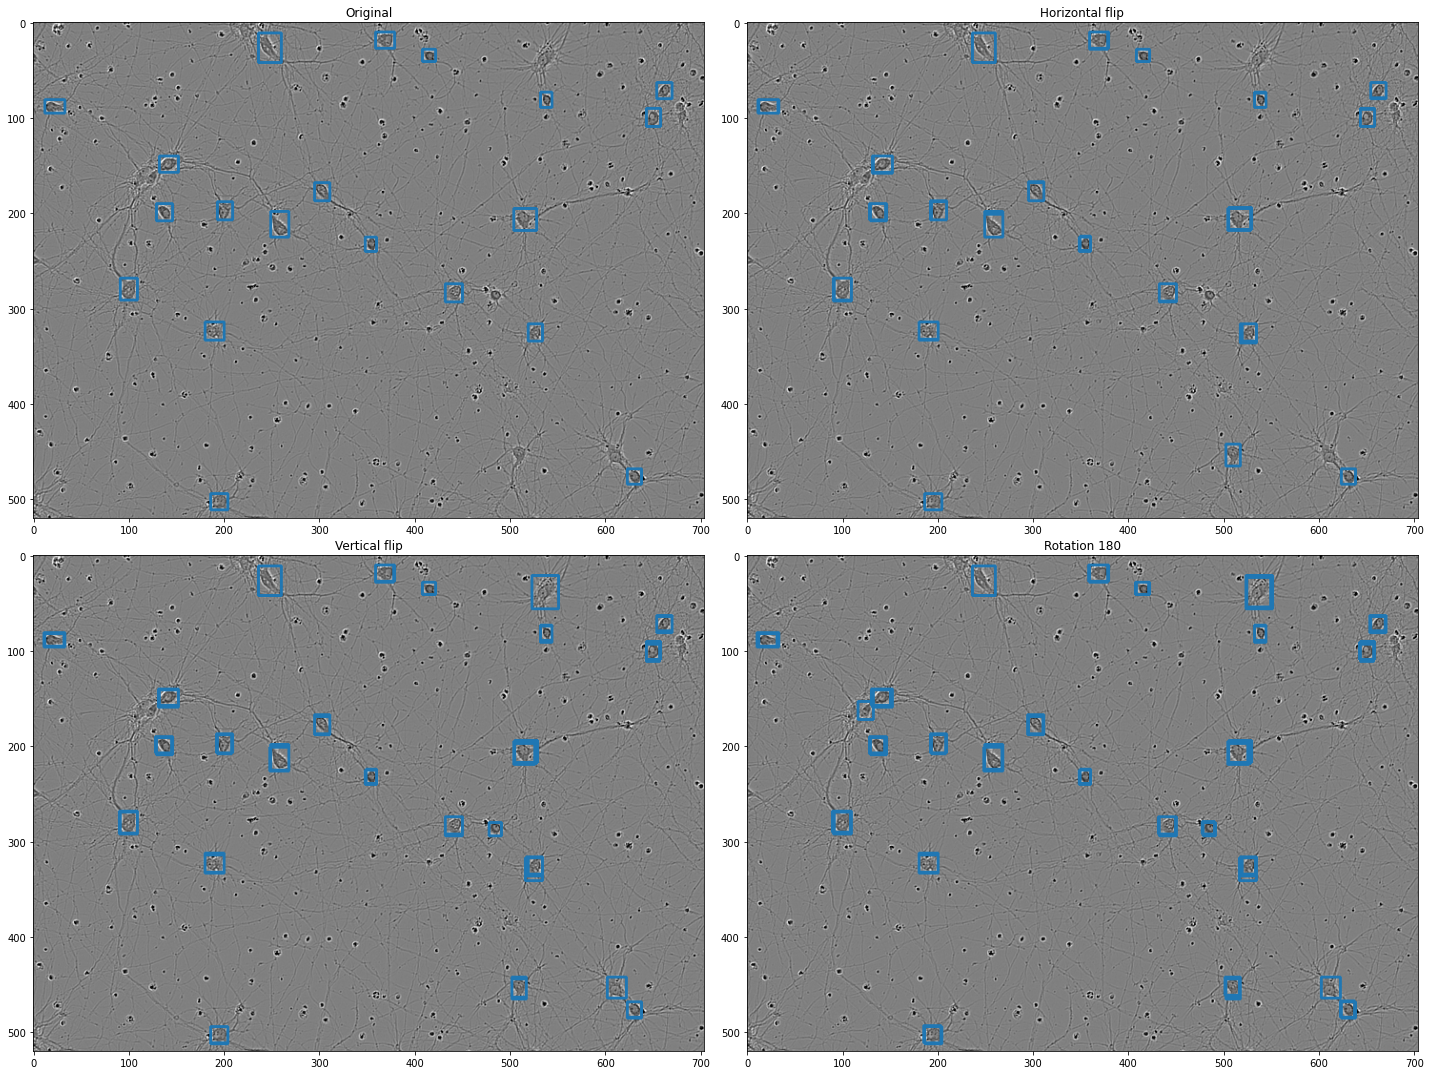

In [11]:
AUGMENTATIONS = [None, A.HorizontalFlip(p=1.0), A.VerticalFlip(p=1.0), A.Rotate(limit=(180,180), p=1.0)]

img_org = cv2.imread(FILE)
boxes, box_scores, masks, masks_lkup, pred_class = TTA(FILE, [predictor20], AUGMENTATIONS)

def show_boxes(im, boxes_list, h, w, color=(31, 119, 180), orig=False):
    thickness = 2
    idx = 0
    if orig:
        idx = 4
    for i in range(len(boxes_list)):
        x1 = int(h * boxes_list[i][idx])
        y1 = int(w * boxes_list[i][idx+1])
        x2 = int(h * boxes_list[i][idx+2])
        y2 = int(w * boxes_list[i][idx+3])
        cv2.rectangle(im, (x1, y1), (x2, y2), color, thickness)
    return im

fig = plt.figure(figsize=(20, 15))
columns = 2
rows = (len(AUGMENTATIONS)//columns) + (len(AUGMENTATIONS) % 2)
for i in range(1,len(AUGMENTATIONS)+1):
    fig.add_subplot(rows, columns, i)
    plt.tight_layout()
    img = img_org
    img = show_boxes(img, boxes[i-1], img.shape[1], img.shape[0])
    plt.title(TITLES[i-1])
    plt.imshow(img)
    
plt.show();

Boxes are all ready for the WSF algorithm. Next, do the same check with the masks:

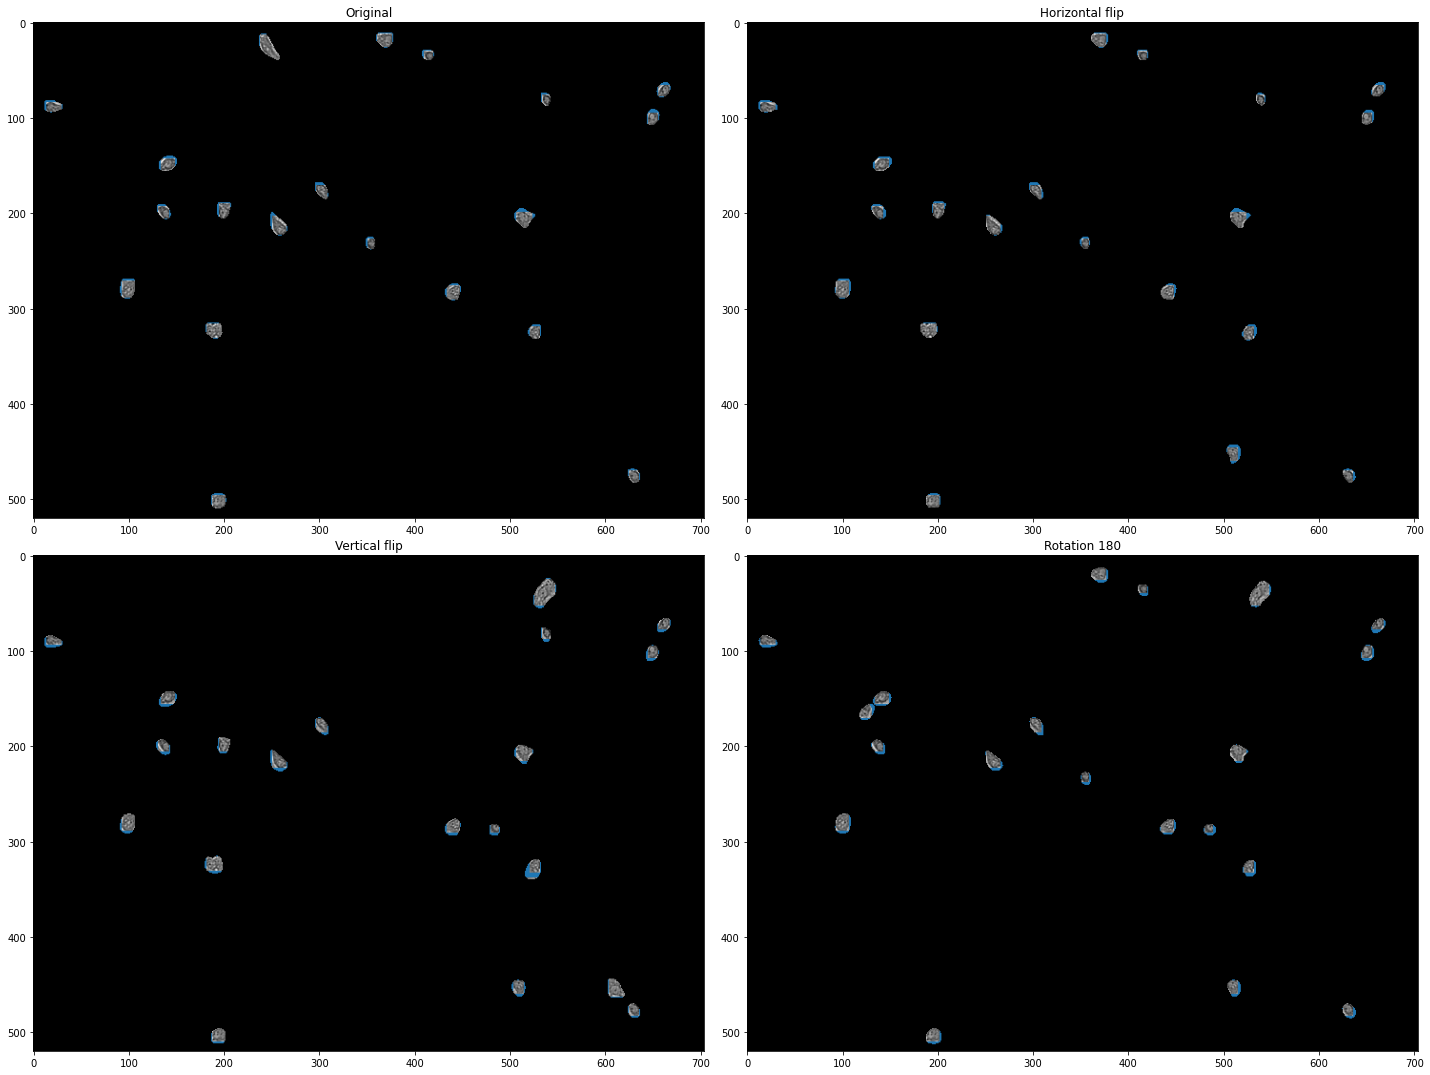

In [12]:
def show_masks(im, masks_list, h, w):
    m = np.zeros((w,h), dtype=np.uint8)
    for i in range(len(masks_list)):
        m = np.logical_or(m, masks_list[i])
    return im * np.dstack([m]*3)

fig = plt.figure(figsize=(20, 15))
columns = 2
rows = (len(AUGMENTATIONS)//columns) + (len(AUGMENTATIONS) % 2)
for i in range(1,len(AUGMENTATIONS)+1):
    fig.add_subplot(rows, columns, i)
    plt.tight_layout()
    img = img_org
    plt.imshow(show_masks(img, masks[i-1], img.shape[1], img.shape[0]))
    plt.title(TITLES[i-1])
plt.show();

All OK - the TTA function is working!

# Weighted Segments Fusion
The Weighted Segments Fusion algorithm is:
  * Make predictions from augmented images (transform boxes and masks back to original) or ensemble models
  * Run WBF on boxes (while keepig track of original boxes and masks)
  * Fuse masks and apply threshold
  * Crop fused mask to WBF box  
  
The first bullet is handled by the `TTA()` function, and the second bullet is handled by the `weighted_boxes_fusion_tracking()` function. The function `get_wsf_mask()` defined below that takes care of the  last two bullets. 

In [13]:
# Fuse masks that belong to fused boxes
def get_wsf_mask(wbf_box, wbf_org, pmasks, pmasks_lkup, thres=0.5):
    w, h = 520, 704
    mask = np.zeros((w, h), dtype=np.uint8)
    for i in range(len(wbf_org)):
        key = bbox_to_key(wbf_org[i][4:])
        model = int(wbf_org[i][3])
        try:
            ind = pmasks_lkup[model][key]
            mask = mask + pmasks[model][ind]
        except:
            pass
    # convert thres to integer based on number of boxes
    threshold = max(1, int(thres*len(wbf_org)))
    # remove pixels outside WBF box
    m2 = np.zeros((w, h), dtype=np.uint8)
    x1 = max(0, int(h * wbf_box[0]))
    y1 = max(0, int(w * wbf_box[1]))
    x2 = min(h, int(h * wbf_box[2]))
    y2 = min(w, int(w * wbf_box[3]))
    m2[y1:y2, x1:x2] = 1
    mask = (mask >= threshold) * m2
    return mask.astype(np.uint8)

# WSF Implementation
Below we define a function `get_masks_tta()` that implements the WSF algorithm for TTA. For completeness we also define `get_masks()` that only makes prediction on a single image.

In [14]:
DEBUG = False

THRESHOLDS = [.53, .45, .55]
CLASS_LABELS = ['shsy5y', 'astro', 'cort']

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# Implement WSF for TTA
def get_masks_tta(fn, pred_list, aug_list, thres=.5):
    im = cv2.imread(str(fn))
    h, w = im.shape[0], im.shape[1]
    # do TTA
    boxes, box_scores, masks, masks_lkup, pred_class = TTA(str(fn), pred_list, aug_list)
    # create dummy labels
    labels = []
    for i in range(len(boxes)):
        labels.append(np.ones(len(boxes[i]), dtype=np.uint8))
    # weighted boxes fusion
    wbf_boxes, wbf_scores, _, wbf_originals = weighted_boxes_fusion_tracking(boxes, 
                                                                             box_scores, 
                                                                             labels_list=labels, 
                                                                             iou_thr=0.55, 
                                                                             skip_box_thr=THRESHOLDS[pred_class])
    # Finally, process masks, making sure there is no overlap
    res = []
    used = np.zeros(im.shape[:2], dtype=int)
    # extract limits from DataFrame
    pred_label = CLASS_LABELS[pred_class+1]
    min_key = pred_label+' min'
    major_axis_len_min = cell_df[cell_df.feature == 'major_axis_len'][min_key].iloc[0]
    # process
    for i in range(len(wbf_boxes)):
        mask = get_wsf_mask(wbf_boxes[i], wbf_originals[i], masks, masks_lkup, thres=thres)
        # get shape properties
        try:
            props = measure.regionprops(mask)
        except:
            continue
        # if there are multiple separated masks, pick the larger one
        areas = []
        for a in range(len(props)):
            areas.append(props[a].area)
        try:
            target = np.argmax(areas)
        except:
            continue
        # extract properties of interest 
        major_axis_len = props[target].major_axis_length
        # check against limits
        if major_axis_len >= major_axis_len_min:
            mask = mask * (1-used)
            # check if mask is chopped up by previous detections
            if len(measure.find_contours(mask, 0.5, positive_orientation='low')) == 1:
                used += mask
                res.append(rle_encode(mask))
            else:
                if DEBUG:
                    print('{}: Chopped\'n\'dropped #{}'.format(fn.split('/')[-1], i))
        else:
            if DEBUG:
                print('{}: Failed limits #{}'.format(fn.split('/')[-1], i))
                
    if DEBUG:
        print('{}: {}, {} boxes of {} left after processing'.format(fn.split('/')[-1], pred_label, len(res), len(wbf_boxes)))
                
    del boxes, box_scores, masks, masks_lkup
    del wbf_boxes, wbf_scores, labels, wbf_originals
    gc.collect()
          
    return res

# Prediction on single image
def get_masks(fn, predictor, thres=-1):
    im = cv2.imread(str(fn))
    pred = predictor(im)
    h, w = pred['instances'].image_size[0], pred['instances'].image_size[1]
    # we are going to apply non-max suppression, so scale boxes to 0-1 range
    pred_boxes = [A.normalize_bbox(box, h, w) for box in pred['instances'].pred_boxes.tensor.cpu().numpy()]
    # create dict with scores and masks with bbox as key
    pred_dict = {}
    for i in range(len(pred_boxes)):
        pred_dict[str(np.round(pred_boxes[i], 6))] = {'box_score': float(pred['instances'].scores[i].cpu().numpy()),
                                                      'mask_score': float(pred['instances'].mask_scores[i].cpu().numpy()),
                                                      'mask': pred['instances'][i].pred_masks.cpu().numpy()[0]*1}
    # non-max suppression (cannot use WBF here or other methods that change the boxes)
    boxes, scores, _ = nms([pred_boxes], 
                           [pred['instances'].scores.detach().cpu().numpy()], 
                           [np.ones(len(pred['instances'].scores))],
                           weights=None, 
                           iou_thr=0.5)
    # class is category with most predictions
    pred_class = torch.mode(pred['instances'].pred_classes)[0] - 1
    # drop predictions with score below threshold
    if thres == -1:
        take = scores >= THRESHOLDS[pred_class]
    else:
        take = scores >= thres
    boxes = boxes[take]
    # Finally, process masks, making sure there is no overlap
    res = []
    used = np.zeros(im.shape[:2], dtype=int)
    # extract limits from DataFrame
    pred_label = CLASS_LABELS[pred_class+1]
    min_key = pred_label+' min'
    major_axis_len_min = cell_df[cell_df.feature == 'major_axis_len'][min_key].iloc[0]
    # process
    for i in range(len(boxes)):
        key = str(np.round(boxes[i], 6))
        if key in pred_dict:
            mask = pred_dict[key]['mask']
            # get shape properties
            try:
                props = measure.regionprops(mask)
            except:
                continue
            # if there are multiple separated masks, pick the larger one
            areas = []
            for a in range(len(props)):
                areas.append(props[a].area)
            try:
                target = np.argmax(areas)
            except:
                continue
            # use filled image as new mask
            mask2 = np.zeros(im.shape[:2], dtype=int)
            try:
                mask2[props[target].bbox[0]:props[target].bbox[2], props[target].bbox[1]:props[target].bbox[3]] = props[target].filled_image
            except:
                continue
            # extract properties of interest 
            major_axis_len = props[target].major_axis_length
            # check against limits
            if major_axis_len >= major_axis_len_min:
                mask2 = mask2 * (1-used)
                # check if mask is chopped up by previous detections
                if len(measure.find_contours(mask2, 0.5, positive_orientation='low')) == 1:
                    used += mask2
                    res.append(rle_encode(mask2))
                else:
                    if DEBUG:
                        print('{}: Chopped\'n\'dropped #{}'.format(fn.split('/')[-1], i))
            else:
                if DEBUG:
                    print('{}: Failed limits #{}'.format(fn.split('/')[-1], i))
        else:
            if DEBUG:
                print('{}: Missing key #{}'.format(fn.split('/')[-1], key))
    if DEBUG:
        print('{}: {}, {} boxes of {} left after processing'.format(fn.split('/')[-1], pred_label, len(res), len(boxes)))
        
    del boxes, scores, pred_dict
    gc.collect()
    return res

Import [cell shape data](https://www.kaggle.com/mistag/sartorius-cell-shape-analysis):

In [15]:
cell_df = pd.read_pickle('/kaggle/input/sartorius-cell-shape-analysis/shape_data.pkl')
cell_df

feature  shsy5y min  shsy5y max  astro min  astro max  cort min  \
0            area      57.000     752.180     46.000   4259.920    70.000   
1  major_axis_len      10.597      63.822     12.204    205.016    11.533   
2  minor_axis_len       6.362      25.255      4.487     67.978     7.264   
3      axis_ratio       0.184       0.940      0.076      0.903     0.326   
4        solidity       0.656       0.972      0.292      0.964     0.806   
5          extent       0.282       0.829      0.104      0.775     0.456   
6            hu_0       0.162       0.534      0.164      1.719     0.160   
7            hu_1       0.000       0.244      0.000      2.864     0.000   

   cort max  
0   776.240  
1    45.296  
2    27.526  
3     0.970  
4     0.979  
5     0.847  
6     0.303  
7     0.059

Configure model for competition grade detections:

In [16]:
from centermask.config import get_cfg # important! Use get_cfg from the centermask repo and not Detectron2

cfg = get_cfg()
cfg.merge_from_file("/kaggle/input/litev39/test.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = '/kaggle/input/litev39/output/model_final.pth'
cfg.MODEL.FCOS.POST_NMS_TOPK_TEST = 800 # Max number of detections per image
predictor = DefaultPredictor(cfg)

## IOU metric
We use IOU calulations from [this notebook](https://www.kaggle.com/theoviel/competition-metric-map-iou). 

In [17]:
def rles_to_mask(encs, shape):
    """
    Decodes a rle.

    Args:
        encs (list of str): Rles for each class.
        shape (tuple [2]): Mask size.

    Returns:
        np array [shape]: Mask.
    """
    img = np.zeros(shape[0] * shape[1], dtype=np.uint)
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc):
            continue
        enc_split = enc.split()
        for i in range(len(enc_split) // 2):
            start = int(enc_split[2 * i]) - 1
            length = int(enc_split[2 * i + 1])
            img[start: start + length] = 1 + m
    return img.reshape(shape)

def compute_iou(labels, y_pred):
    """
    Computes the IoU for instance labels and predictions.

    Args:
        labels (np array): Labels.
        y_pred (np array): predictions

    Returns:
        np array: IoU matrix, of size true_objects x pred_objects.
    """

    true_objects = len(np.unique(labels))
    pred_objects = len(np.unique(y_pred))

    # Compute intersection between all objects
    intersection = np.histogram2d(
        labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects)
    )[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins=true_objects)[0]
    area_pred = np.histogram(y_pred, bins=pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection
    iou = intersection / union
    
    return iou[1:, 1:]  # exclude background

def precision_at(threshold, iou):
    """
    Computes the precision at a given threshold.

    Args:
        threshold (float): Threshold.
        iou (np array): IoU matrix.

    Returns:
        int: Number of true positives,
        int: Number of false positives,
        int: Number of false negatives.
    """
    matches = iou > threshold
    true_positives = np.sum(matches, axis=1) == 1  # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
    tp, fp, fn = (
        np.sum(true_positives),
        np.sum(false_positives),
        np.sum(false_negatives),
    )
    return tp, fp, fn

def iou_map(truths, preds, verbose=0):
    """
    Computes the metric for the competition.
    Masks contain the segmented pixels where each object has one value associated,
    and 0 is the background.

    Args:
        truths (list of masks): Ground truths.
        preds (list of masks): Predictions.
        verbose (int, optional): Whether to print infos. Defaults to 0.

    Returns:
        float: mAP.
    """
    ious = [compute_iou(truth, pred) for truth, pred in zip(truths, preds)]

    if verbose:
        print("Thresh\tTP\tFP\tFN\tPrec.")

    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        tps, fps, fns = 0, 0, 0
        for iou in ious:
            tp, fp, fn = precision_at(t, iou)
            tps += tp
            fps += fp
            fns += fn

        p = tps / (tps + fps + fns)
        prec.append(p)

        if verbose:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tps, fps, fns, p))

    if verbose:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))

    return np.mean(prec)

## Test WSF implementation
Below we will test prediction on an image from the test set of the trained model, and compare the score of TTA+WSF algorithm with plain vanilla prediction:

In [18]:
# helper function to vizualize prediction
def viz_pred(fid, use_tta=False):
    idx = df.index[df.id == fid][0]
    shape = df[['height', 'width']].values[idx]
    rles = df[df.id == fid].annotation.iloc[0]
    masks = rles_to_mask(rles, shape).astype(np.uint16)
    fig, ax = plt.subplots(1, 2, figsize=(24,12))
    fig.tight_layout()
    plt.subplot(1,2,1)
    plt.imshow(masks)
    plt.axis(False)
    plt.title('Ground truth {}'.format(fid))
    plt.subplot(1,2,2)
    f = '/kaggle/input/sartorius-cell-instance-segmentation/train/'+fid+'.png'
    if not use_tta:
        y_masks = get_masks(f, predictor)
    else:
        y_masks = get_masks_tta(f, [predictor], AUGMENTATIONS)
    y_mask = rles_to_mask(y_masks, shape).astype(np.uint16)
    plt.imshow(y_mask)
    plt.axis(False)
    ap = iou_map([masks] , [y_mask], verbose=0)
    plt.title('Prediction, mAP={}'.format(round(ap,3)))
    plt.show();

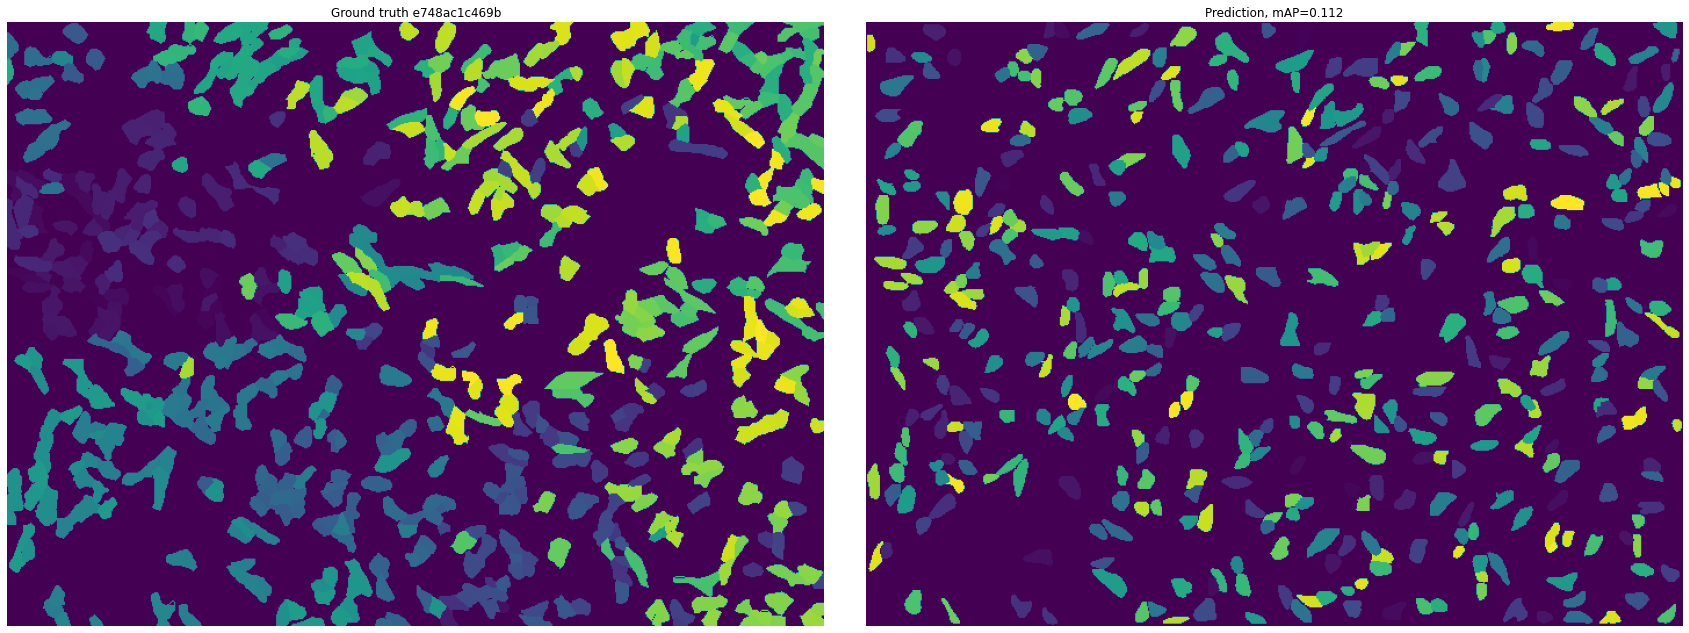

In [19]:
viz_pred(test_fids[0])

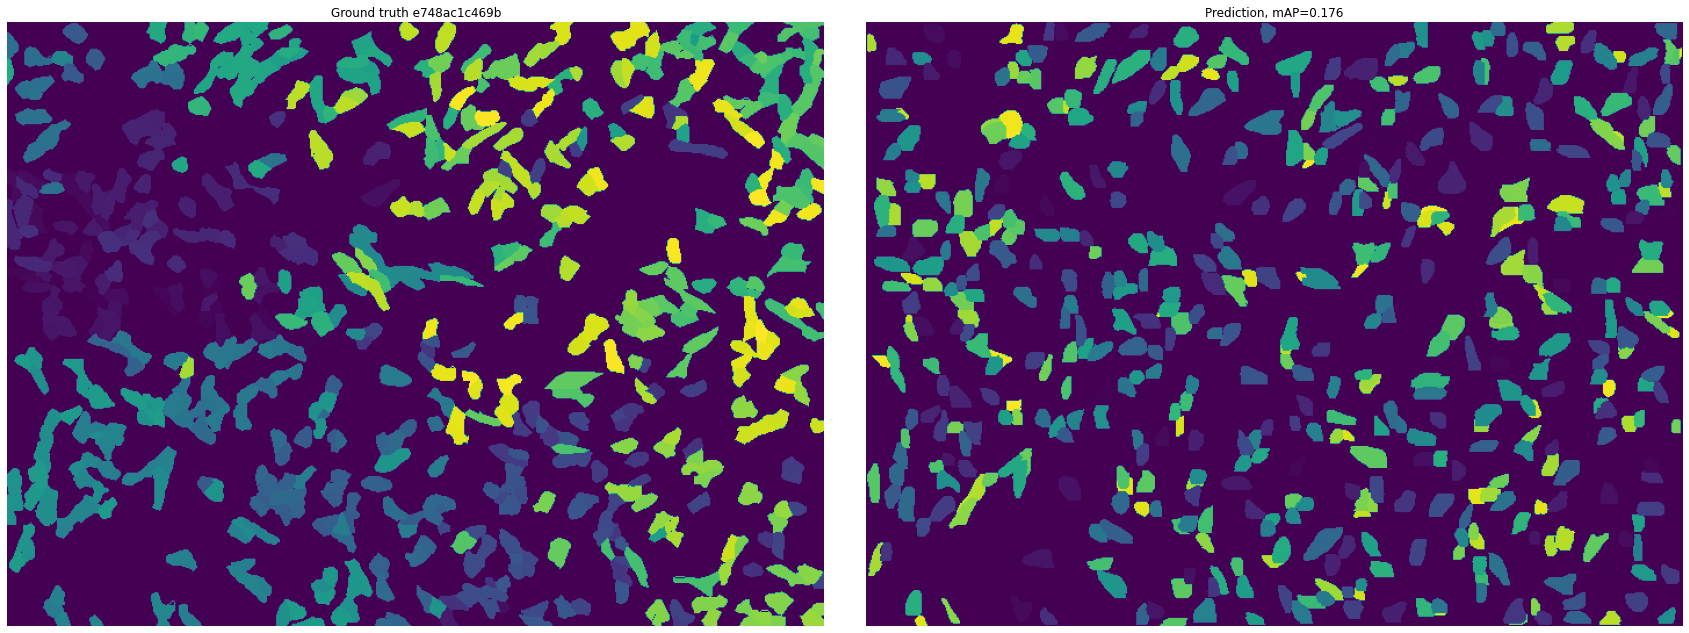

In [20]:
viz_pred(test_fids[0], use_tta=True)

The mAP is increased from 0.112 to 0.176 - pretty good! Another one:

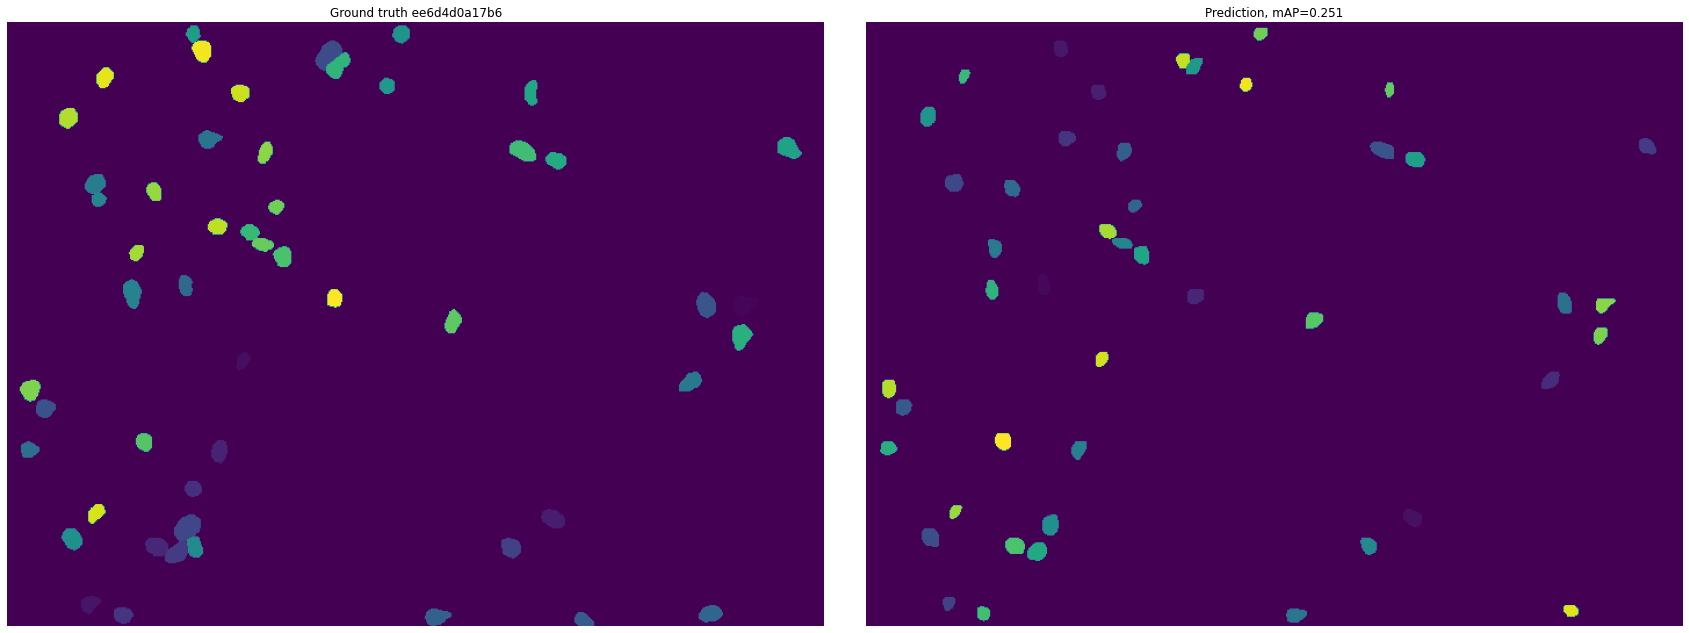

In [21]:
viz_pred(test_fids[10])

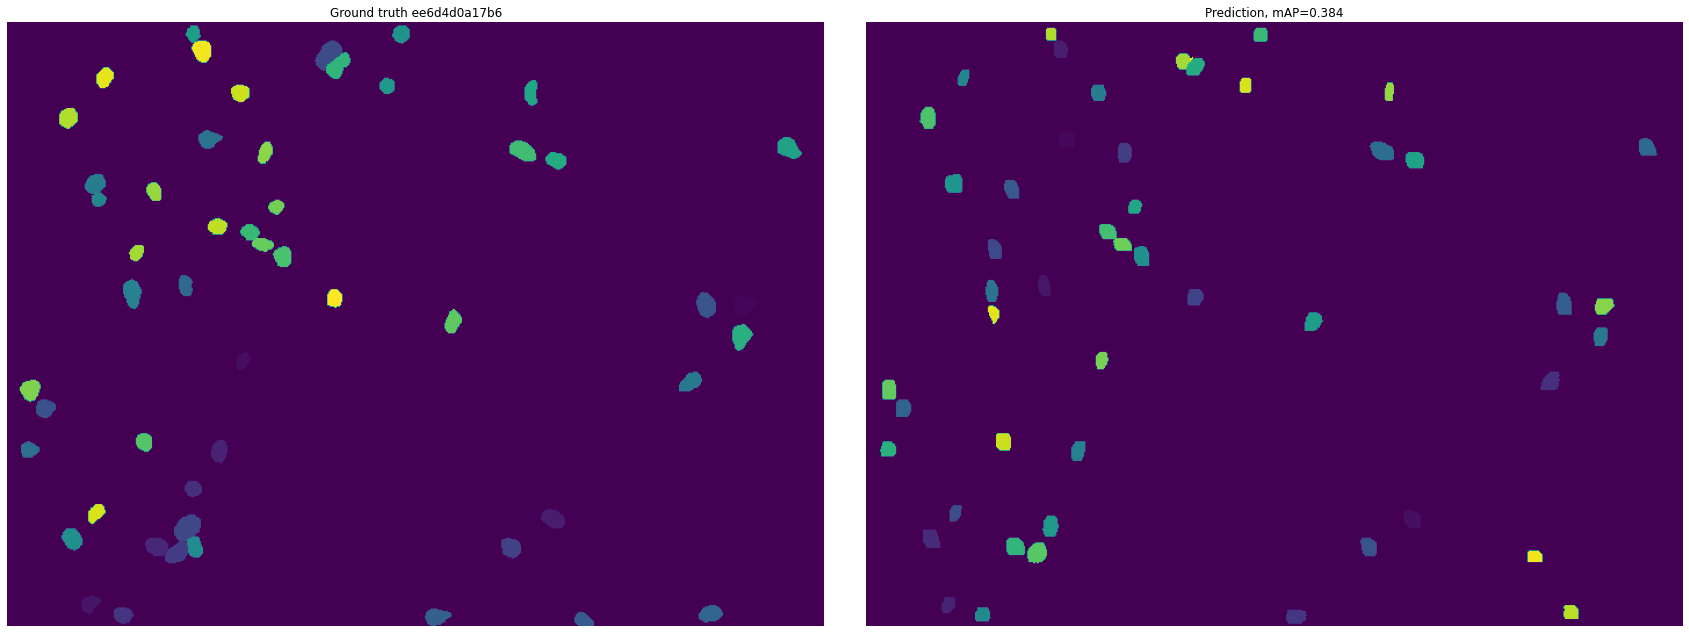

In [22]:
viz_pred(test_fids[10], use_tta=True)

mAP is improved from 0.251 to 0.384